# Conformal classification using CV+ in a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

This tutorial demonstrates how to use `CoverForestClassifier` in a scikit-learn pipeline for CV+ conformal classification on the breast cancer dataset.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from coverforest import CoverForestClassifier
from coverforest.metrics import average_set_size_loss, classification_coverage_score

Load the dataset and split it into training and testing sets

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Making a pipeline

We'll create a scikit-learn pipeline that normalizes the features first before fitting with `CoverForestClassifier`.

In [3]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            CoverForestClassifier(
                n_estimators=100, method="cv", cv=10, random_state=0, verbose=1
            ),
        ),
    ]
)

We'll now fit the pipeline on the training data.

In [4]:
pipe.fit(X_train, y_train)

Searching regularization parameters...
Fitting with k = 1 and lambda = 0.1.


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 CoverForestClassifier(cv=10, n_estimators=100, random_state=0,
                                       verbose=1))])

At the default setting, the `fit()` method performs a hyperparameter search before the actual fitting, which as a result yields `k = 1` and `lambda = 0.1`.

## Inspecting individual forest

In constrast to scikit-learn's `RandomForestClassifier`, each subestimator in a `CoverForestClassifier(method='cv')` is a `FastRandomForestClassifier`, a modification of `RandomForestClassifier` that skips all input checks for faster training times.

In [5]:
all_forests = pipe["clf"].estimators_
first_forest = all_forests[0]

first_forest

FastRandomForestClassifier(random_state=1162135467)

This class retains all `RandomForestClassifier`'s post-train attributes and methods.

For example, we can plot individual trees in each forest.

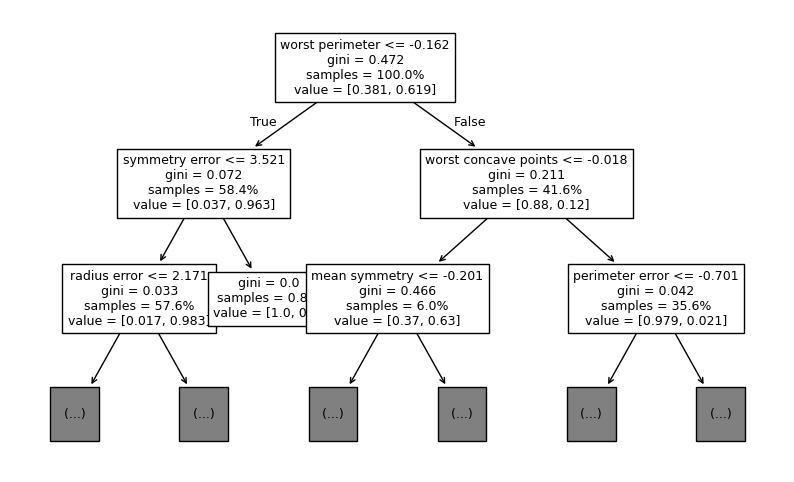

In [6]:
plt.figure(figsize=(10, 6))
first_tree = first_forest.estimators_[0]
tree.plot_tree(
    first_tree,
    feature_names=pipe["scaler"].get_feature_names_out(),
    max_depth=2,
    proportion=True,
    fontsize=9,
)
plt.show()

As another example, we plot the feature importances in each forest.

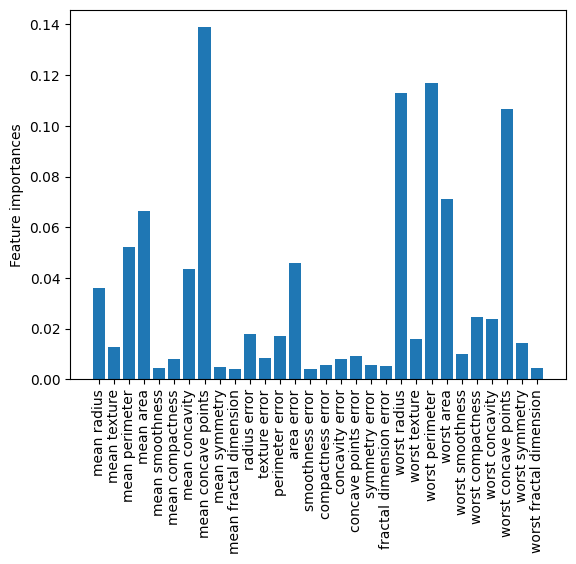

In [7]:
names = pipe["scaler"].get_feature_names_out()
importances = first_forest.feature_importances_

fig, ax = plt.subplots()
ax.bar(names, importances)
ax.set_ylabel("Feature importances")
ax.tick_params(axis="x", labelrotation=90)
plt.show()

Let's visualize the variable importances across all forests by plotting the means with 1-sd error bars.

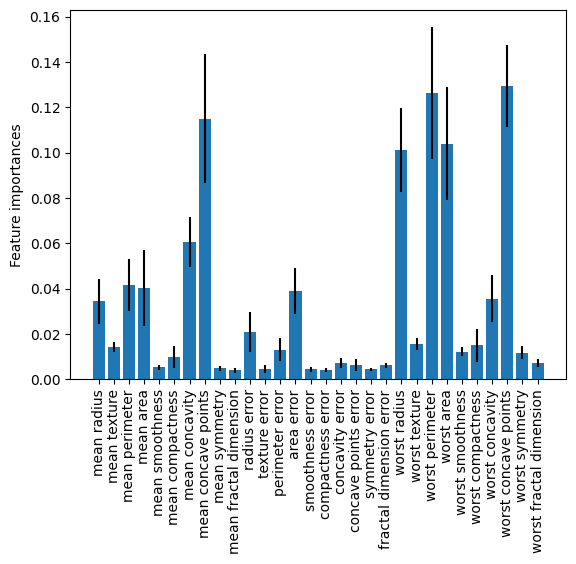

In [8]:
names = pipe["scaler"].get_feature_names_out()
imp_all = [all_forests[i].feature_importances_ for i in range(len(all_forests))]
imp_mean = np.mean(imp_all, axis=0)
imp_std = np.std(imp_all, axis=0)

fig, ax = plt.subplots()
ax.bar(names, imp_mean, yerr=imp_std)
ax.set_ylabel("Feature importances")
ax.tick_params(axis="x", labelrotation=90)
plt.show()

## Making set predictions

Now we'll make predictions with 95% coverage ($\alpha=0.05$). This will return both the point predictions and the set predictions.

In [9]:
y_pred, y_sets = pipe.predict(X_test, alpha=0.05)

Here, `y_pred` is an array of point predictions, which are the single most likely classes predicted by the model. `y_sets` is a list that contains set predictions.

Let's compare between the true classes, the single predictions and the set predictions.

In [10]:
for i in range(10, 20):
    print(f"True: {y_test.iloc[i]}, Pred: {y_pred[i]}, Set: {y_sets[i]}")

True: 1, Pred: 0, Set: [0 1]
True: 1, Pred: 1, Set: [1]
True: 1, Pred: 1, Set: [1]
True: 1, Pred: 0, Set: [0 1]
True: 1, Pred: 0, Set: [0 1]
True: 0, Pred: 0, Set: [0 1]
True: 1, Pred: 1, Set: [1]
True: 0, Pred: 0, Set: [0]
True: 0, Pred: 0, Set: [0]
True: 0, Pred: 0, Set: [0]


All test samples with incorrection have both classes in the prediction sets, indicating that the model outputs both classes when they are uncertain about their single predictions.

## Evaluations

The `coverforest.metrics` module provides two metrics for evaluation of set predictions.

- `average_set_size_loss` calculates the average set size. Small values indicate that our model is quite confident in its predictions.
- `classification_coverage_score` calculates the *empirical coverage`, that is, the proportion of sets that contain the true classes. Higher coverage scores are better, especially when making risky decisions.  The standard guaranteed lower bound on the coverage probability is $1-2\alpha$. Nonetheless, in practice, a good conformal algorithm should have empirical coverage more than $1-\alpha$.

In [11]:
print(f"Average set size: {average_set_size_loss(y_test, y_sets)}")
print(f"Empirical coverage: {classification_coverage_score(y_test, y_sets)}")

Average set size: 1.105263157894737
Empirical coverage: 0.9824561403508771


In this particular example, the empirical coverage is above the specified coverage level of 0.982. The average set size of 1.105 indicates that the random forest can output a single label with high confidence.

## Comparison with Jackknife+-after-bootstrap and split conformal

Let's try the remaining two conformal classification methods, namely the Jackknife+-after-bootstrap and split conformal methods and see how they perform compared to CV+.

### Jackknife+-after-bootstrap

The model is exactly the same as a regular random forest, but now it keeps track of which samples haven't been trained by each tree for out-of-bag score calculations.

In [12]:
pipe_b = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf_b",
            CoverForestClassifier(n_estimators=400, method="bootstrap", random_state=0),
        ),
    ]
)
pipe_b.fit(X_train, y_train)
y_b_pred, y_b_sets = pipe_b.predict(X_test, alpha=0.05)

In [13]:
print(f"Average set size: {average_set_size_loss(y_test, y_b_sets)}")
print(f"Empirical coverage: {classification_coverage_score(y_test, y_b_sets)}")

Average set size: 1.105263157894737
Empirical coverage: 0.9824561403508771


### Split conformal

In [14]:
pipe_sp = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf_sp",
            CoverForestClassifier(n_estimators=400, method="split", random_state=0),
        ),
    ]
)
pipe_sp.fit(X_train, y_train)
y_sp_pred, y_sp_sets = pipe_sp.predict(X_test, alpha=0.05)

In [15]:
print(f"Average set size: {average_set_size_loss(y_test, y_sp_sets)}")
print(f"Empirical coverage: {classification_coverage_score(y_test, y_sp_sets)}")

Average set size: 1.105263157894737
Empirical coverage: 0.9649122807017544


We can see that the split conformal provides a slightly smaller coverage than the other two methods and a larger average set size.

## Final notes

1. The methods used for constructing prediction sets are different variations of the adaptive prediction set (APS) method introduced in {footcite:t}`Romano2020`.
2. The CV+ method is the only one with random forests as the sub-estimators
3. The CV+ method also comes with additional parameters, namely:
   - `k_init='auto'` and `lambda_init='auto'`: Initial regularization parameters
   - `allow_empty_sets=True`: Whether empty prediction sets are allowed
   - `randomized=True`: Whether to include one more class to the set prediction at random.

   It is recommended that:
   - If many of the set predictions are empty, it is recommended to increase the target coverage rate (decrease $\alpha$) until most sets are nonempty.
   - When `allow_empty_sets=False`, an additional class is added to all prediction sets, not only the empty ones, due to the exchangeability requirement of conformal prediction. This leads to larger prediction sets overall, so this option should only be used sparingly.
4. In the case of Jackknife+-after-bootstrap, the coverage guarantee in {footcite:t}`Kim2020` relies on resampling the forest's tree count from $\operatorname{Binomial}(B (1-1/n)^m)$, where:
   - $B$ is the initial number of trees
   - $n$ is the number of training samples
   - $m$ is the number of bootstrap samples.

   The `fit()` method in `CoverForestClassifier` automatically sets $B= \text{n_estimators}/(1-1/n)^m$ so that, on average, the number of trees to be fitted is $\text{n_estimators}$, with standard deviation of $\sqrt{\text{n_estimators}*(1- (1-1/n)^m)}$.

   `CoverForestClassifier` also provides an option not to resample the number of sub-estimators by initiating  with `resample_n_estimators=False`.
5. Random forest leverages parallel computation by processing trees concurrently. Use the `n_jobs` parameter in `fit()` and `predict()` to control CPU usage (`n_jobs=-1` uses all cores).
7. For prediction, conformity score calculations require a memory array of size `(n_train × n_test × n_classes)`. To optimize performance with high `n_jobs` values, split large test sets into smaller batches.

```{bibliography} references.bib
```